# Naïve Bayes – Previsão de Evasão e Sucesso Acadêmico

Este notebook treina e avalia um classificador **Gaussian Naïve Bayes** usando os dados já pré-processados (40 features numéricas + coluna‐alvo). Também traz estatísticas que ajudam a interpretar o modelo.

> Dataset: *Predict Students' Dropout and Academic Success* – UCI ML Repository



In [55]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, balanced_accuracy_score)
from sklearn.model_selection import (StratifiedKFold, RepeatedStratifiedKFold,
                                     GridSearchCV, RandomizedSearchCV, cross_validate)
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Pipeline SEM vazamento + oversampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # troque para SMOTENC se tiver colunas categóricas identificáveis

# Visual
plt.rcParams["figure.figsize"] = (10,8)
np.set_printoptions(edgeitems=3, suppress=True)


In [39]:
def find_paths():
    candidates = [
        (Path("./train.csv"), Path("./test.csv")),
        (Path("../Data/train.csv"), Path("../Data/test.csv")),
        (Path("/mnt/data/train.csv"), Path("/mnt/data/test.csv")),
    ]
    for tr, te in candidates:
        if tr.exists() and te.exists():
            return tr, te
    raise FileNotFoundError("Não encontrei train.csv/test.csv. Ajuste os caminhos na célula 2.")

train_path, test_path = find_paths()
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

TARGET_COL = "Target"  # ajuste se o nome for diferente
X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]
X_test  = test_df.drop(columns=[TARGET_COL])
y_test  = test_df[TARGET_COL]

print("Shapes:", X_train.shape, X_test.shape)
print("Distribuição treino:", y_train.value_counts().to_dict())
print("Distribuição teste :", y_test.value_counts().to_dict())


Shapes: (5301, 40) (885, 40)
Distribuição treino: {2: 1767, 0: 1767, 1: 1767}
Distribuição teste : {2: 442, 0: 284, 1: 159}


In [41]:
def eval_and_print(y_true, y_pred, title=""):
    acc   = accuracy_score(y_true, y_pred)
    f1m   = f1_score(y_true, y_pred, average="macro")
    balc  = balanced_accuracy_score(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Accuracy       : {acc:.4f}")
    print(f"F1-macro       : {f1m:.4f}")
    print(f"Balanced Acc   : {balc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    return {"model": title, "accuracy": acc, "f1_macro": f1m, "bal_acc": balc}

results = []


In [51]:
param_grid = {"var_smoothing": np.logspace(-12, -1, 12)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train, y_train)

print("Melhor var_smoothing:", gs.best_params_["var_smoothing"])
print("F1-macro (CV):", gs.best_score_)

nb_gs = gs.best_estimator_
y_pred_gs = nb_gs.predict(X_test)
results.append(eval_and_print(y_test, y_pred_gs, f"GaussianNB (GridSearch, vs={gs.best_params_['var_smoothing']:.2e})"))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhor var_smoothing: 0.0001
F1-macro (CV): 0.6673103113852894

=== GaussianNB (GridSearch, vs=1.00e-04) ===
Accuracy       : 0.6520
F1-macro       : 0.6090
Balanced Acc   : 0.6147

Classification Report:
              precision    recall  f1-score   support

           0     0.7203    0.6620    0.6899       284
           1     0.3289    0.4717    0.3876       159
           2     0.7929    0.7104    0.7494       442

    accuracy                         0.6520       885
   macro avg     0.6141    0.6147    0.6090       885
weighted avg     0.6863    0.6520    0.6653       885

Confusion Matrix:
[[188  61  35]
 [ 37  75  47]
 [ 36  92 314]]


In [52]:
pipe_nb = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("nb", GaussianNB(var_smoothing=gs.best_params_["var_smoothing"]))
])

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = {"accuracy": "accuracy", "f1_macro": "f1_macro", "bal_acc": "balanced_accuracy"}

cv_res = cross_validate(pipe_nb, X_train, y_train, cv=rskf, scoring=scoring, n_jobs=-1)
print("=== CV (Pipeline[SMOTE->GaussianNB]) ===")
for k in ["accuracy","f1_macro","bal_acc"]:
    vals = cv_res[f"test_{k}"]
    print(f"{k:10s}: {vals.mean():.4f} ± {vals.std():.4f}")

pipe_nb.fit(X_train, y_train)
y_pred_pipe = pipe_nb.predict(X_test)
results.append(eval_and_print(y_test, y_pred_pipe, "Pipeline[SMOTE->GaussianNB] (hold-out)"))


=== CV (Pipeline[SMOTE->GaussianNB]) ===
accuracy  : 0.6689 ± 0.0140
f1_macro  : 0.6693 ± 0.0140
bal_acc   : 0.6689 ± 0.0140

=== Pipeline[SMOTE->GaussianNB] (hold-out) ===
Accuracy       : 0.6520
F1-macro       : 0.6090
Balanced Acc   : 0.6147

Classification Report:
              precision    recall  f1-score   support

           0     0.7203    0.6620    0.6899       284
           1     0.3289    0.4717    0.3876       159
           2     0.7929    0.7104    0.7494       442

    accuracy                         0.6520       885
   macro avg     0.6141    0.6147    0.6090       885
weighted avg     0.6863    0.6520    0.6653       885

Confusion Matrix:
[[188  61  35]
 [ 37  75  47]
 [ 36  92 314]]


Classes: [0 1 2]
Priors: [0.33333333 0.33333333 0.33333333]


Curricular units 2nd sem (approved)       1.861566
Curricular units 2nd sem (grade)          1.582070
Curricular units 1st sem (approved)       1.466146
Curricular units 1st sem (grade)          1.253457
Tuition fees up to date_1                 0.803259
Gender_1                                  0.670388
Debtor_1                                  0.618814
Scholarship holder_1                      0.595618
Age at enrollment                         0.554966
Application mode                          0.517059
Curricular units 2nd sem (enrolled)       0.425648
Curricular units 1st sem (enrolled)       0.381028
Marital status_2                          0.296438
Application order                         0.295044
Curricular units 2nd sem (evaluations)    0.280567
dtype: float64

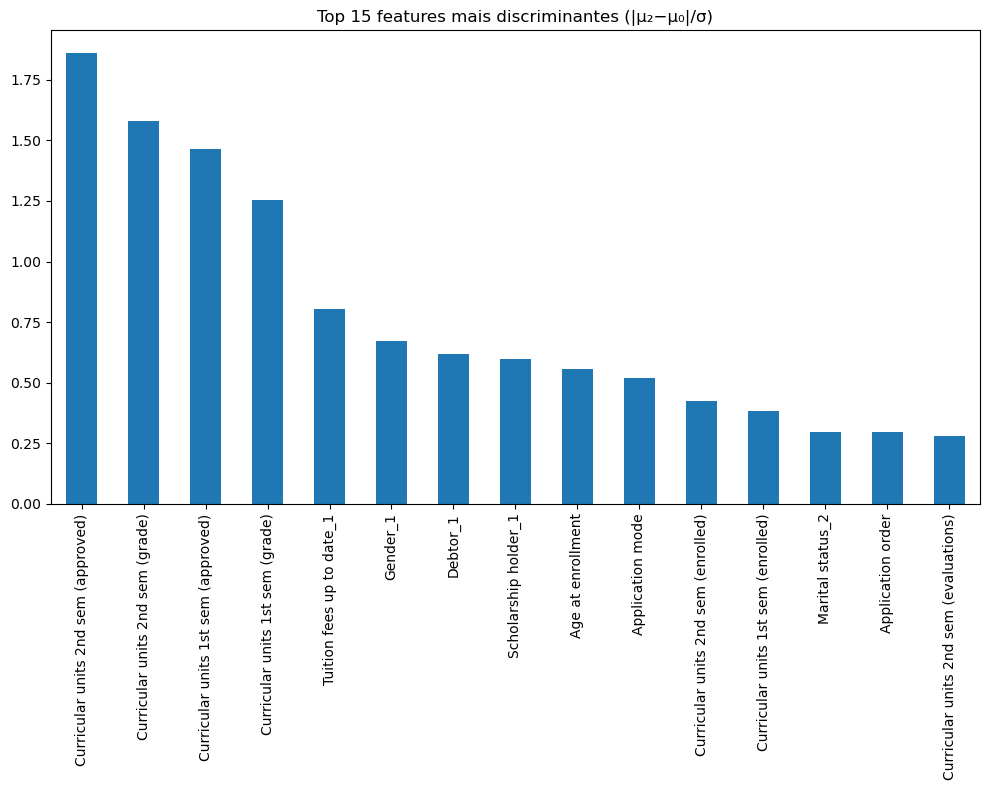

In [56]:
nb_view = nb_gs  # usa o modelo do GridSearch para inspecionar parâmetros
print("Classes:", nb_view.classes_)
print("Priors:", nb_view.class_prior_)

means = pd.DataFrame(nb_view.theta_, index=nb_view.classes_, columns=X_train.columns)
vars_  = pd.DataFrame(nb_view.var_,   index=nb_view.classes_, columns=X_train.columns)

if 0 in means.index and 2 in means.index:
    diff = (means.loc[2] - means.loc[0]).abs()
    pooled_sigma = np.sqrt(vars_.mean())
    importance = (diff / pooled_sigma).sort_values(ascending=False)
    display(importance.head(15))
    importance.head(15).plot(kind="bar", title="Top 15 features mais discriminantes (|μ₂−μ₀|/σ)")
    plt.tight_layout(); plt.show()
else:
    print("Ajuste o par de classes para o ranking (ex.: 0 vs 2).")


In [57]:
# Tabela final sem entradas duplicadas
clean_res_df = pd.DataFrame(results).drop_duplicates().sort_values(
    by=["f1_macro", "bal_acc"], ascending=False
).reset_index(drop=True)
clean_res_df


,model,accuracy,f1_macro,bal_acc
0,GaussianNB + CalibratedClassifierCV(sigmoid),0.654237,0.609949,0.615278
1,"GaussianNB (GridSearch, vs=1.00e-04)",0.651977,0.608969,0.614692
2,Pipeline[SMOTE->GaussianNB] (hold-out),0.651977,0.608969,0.614692
3,GaussianNB (baseline),0.655367,0.536792,0.540612
